In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
import joblib




In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "chavindudulaj/vehicle-maintenance-data",
    "vehicle_maintenance_data.csv"
)

print("Shape:", df.shape)
print(df.head())



Shape: (50000, 20)
  Vehicle_Model  Mileage Maintenance_History  Reported_Issues  Vehicle_Age  \
0         Truck    58765                Good                0            4   
1           Van    60353             Average                1            7   
2           Bus    68072                Poor                0            2   
3           Bus    60849             Average                4            5   
4           Bus    45742                Poor                5            1   

  Fuel_Type Transmission_Type  Engine_Size  Odometer_Reading  \
0  Electric         Automatic         2000             28524   
1  Electric         Automatic         2500            133630   
2  Electric         Automatic         1500             34022   
3    Petrol         Automatic         2500             81636   
4    Petrol            Manual         2000             97162   

  Last_Service_Date Warranty_Expiry_Date Owner_Type  Insurance_Premium  \
0        2023-11-23           2025-06-24     Second  

In [3]:
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:\n", df["Need_Maintenance"].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Vehicle_Model         50000 non-null  object 
 1   Mileage               50000 non-null  int64  
 2   Maintenance_History   50000 non-null  object 
 3   Reported_Issues       50000 non-null  int64  
 4   Vehicle_Age           50000 non-null  int64  
 5   Fuel_Type             50000 non-null  object 
 6   Transmission_Type     50000 non-null  object 
 7   Engine_Size           50000 non-null  int64  
 8   Odometer_Reading      50000 non-null  int64  
 9   Last_Service_Date     50000 non-null  object 
 10  Warranty_Expiry_Date  50000 non-null  object 
 11  Owner_Type            50000 non-null  object 
 12  Insurance_Premium     50000 non-null  int64  
 13  Service_History       50000 non-null  int64  
 14  Accident_History      50000 non-null  int64  
 15  Fuel_Efficiency    

In [4]:
df["Last_Service_Date"] = pd.to_datetime(df["Last_Service_Date"])
df["Warranty_Expiry_Date"] = pd.to_datetime(df["Warranty_Expiry_Date"])

reference_date = pd.Timestamp("2024-01-01")
df["Days_Since_Service"] = (reference_date - df["Last_Service_Date"]).dt.days
df["Days_Until_Warranty"] = (df["Warranty_Expiry_Date"] - reference_date).dt.days

df = df.drop(columns=["Last_Service_Date", "Warranty_Expiry_Date"])

print("Updated shape:", df.shape)
print(df[["Days_Since_Service", "Days_Until_Warranty"]].head())


Updated shape: (50000, 20)
   Days_Since_Service  Days_Until_Warranty
0                  39                  540
1                 102                  520
2                 188                  482
3                 130                  674
4                 221                  622


In [5]:
corr = df.corr(numeric_only=True)["Need_Maintenance"].abs().sort_values(ascending=False)
print(corr)


Need_Maintenance       1.000000
Reported_Issues        0.389273
Service_History        0.104155
Accident_History       0.080590
Odometer_Reading       0.007876
Days_Until_Warranty    0.007658
Insurance_Premium      0.004775
Fuel_Efficiency        0.001874
Vehicle_Age            0.000806
Mileage                0.000704
Days_Since_Service     0.000435
Engine_Size            0.000326
Name: Need_Maintenance, dtype: float64


In [6]:
X = df.drop("Need_Maintenance", axis=1)
y = df["Need_Maintenance"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)



Numeric features: ['Mileage', 'Reported_Issues', 'Vehicle_Age', 'Engine_Size', 'Odometer_Reading', 'Insurance_Premium', 'Service_History', 'Accident_History', 'Fuel_Efficiency', 'Days_Since_Service', 'Days_Until_Warranty']
Categorical features: ['Vehicle_Model', 'Maintenance_History', 'Fuel_Type', 'Transmission_Type', 'Owner_Type', 'Tire_Condition', 'Brake_Condition', 'Battery_Status']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)




Train size: (40000, 19)
Test size: (10000, 19)


In [8]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_leaf=20, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=20, random_state=42)
}



In [9]:
results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])
    results[name] = {"Accuracy": acc, "ROC-AUC": roc}

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

print("\nModel Comparison:")
print(pd.DataFrame(results).T)



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1900
           1       0.97      0.97      0.97      8100

    accuracy                           0.95     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.95      0.95      0.95     10000


=== Decision Tree ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       1.00      1.00      1.00      8100

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       1.00      1.00      1.00      8100

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
    print(f"{name}: ROC-AUC = {scores.mean():.4f} ± {scores.std():.4f}")


Logistic Regression: ROC-AUC = 0.9876 ± 0.0005
Decision Tree: ROC-AUC = 1.0000 ± 0.0000
Random Forest: ROC-AUC = 1.0000 ± 0.0000


In [11]:
best_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

best_pipe.fit(X_train, y_train)
y_pred_best = best_pipe.predict(X_test)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred_best))


Final Model Accuracy: 0.954


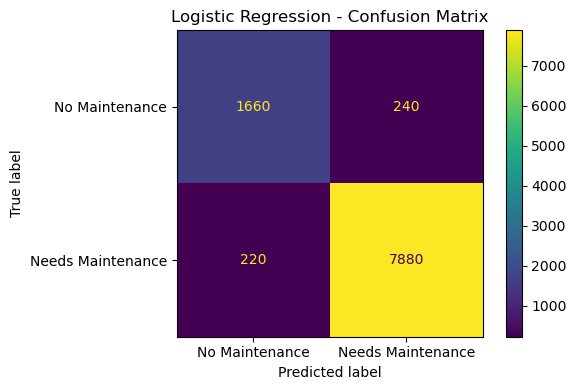

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_best, ax=ax,
    display_labels=["No Maintenance", "Needs Maintenance"]
)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()



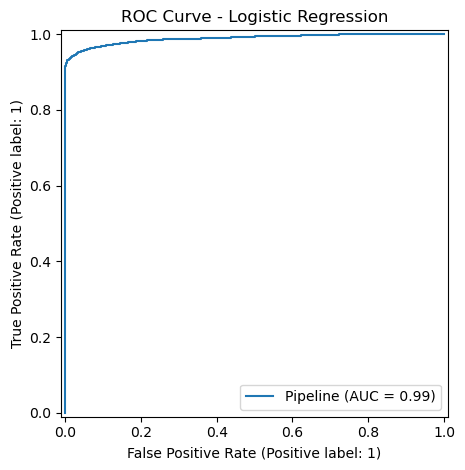

In [13]:
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()


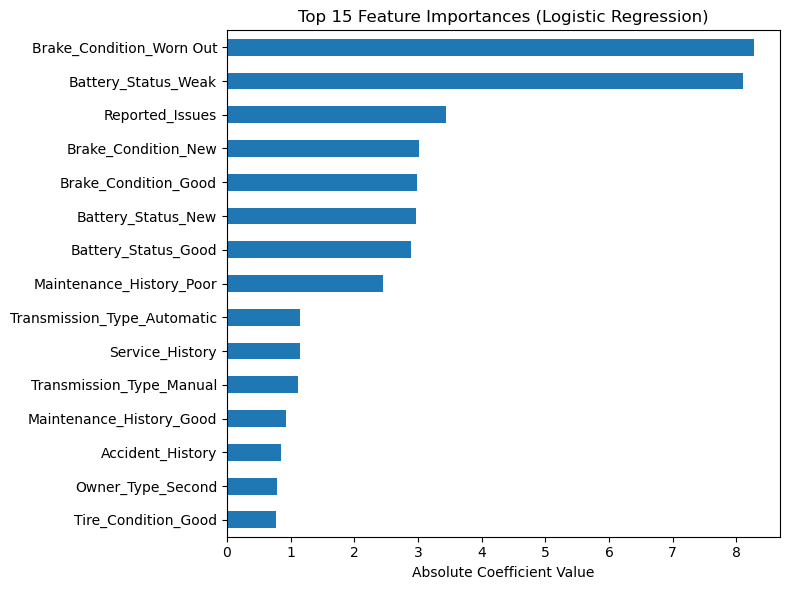

In [14]:
ohe_features = best_pipe.named_steps['preprocessor'] \
               .named_transformers_['cat'] \
               .get_feature_names_out(cat_features).tolist()
all_features = num_features + ohe_features

coefs = best_pipe.named_steps['model'].coef_[0]
feat_imp = pd.Series(coefs, index=all_features).abs().sort_values(ascending=False)

feat_imp.head(15).plot(kind='barh', figsize=(8, 6))
plt.title("Top 15 Feature Importances (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()


In [15]:
joblib.dump(best_pipe, "vehicle_maintenance_pipeline.pkl")
print("Model saved as vehicle_maintenance_pipeline.pkl")


Model saved as vehicle_maintenance_pipeline.pkl
